In [1]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

train = read_data('./data/Multil_label_data/train.tsv')
validation = read_data('./data/Multil_label_data/validation.tsv')

print(len(train))
print(len(validation))
train.sample(10)

100000
30000


,title,tags
48222,how to dynamically get the image from the wind...,"[c#, sql-server, winforms, image]"
8119,numpy ndarrays: row-wise and column-wise opera...,"[python, arrays, numpy]"
10857,Create a tilt-shift filter like instagram in o...,"[objective-c, ios]"
44403,How to simulate the Out Of memory : Requested ...,[java]
66683,PHP: URL friendly strings,"[php, string]"
88655,Why are extension methods only allowed in non-...,[c#]
41863,Can't reference controls in code behind. Visua...,"[asp.net, vb.net]"
57150,SQL and Java return different dates?,"[java, sql, sql-server, date]"
64002,How can I determine how much memory my program...,"[c#, .net]"
69521,Android: Pause/Resume Timer OR Thread,"[java, android, multithreading]"


In [3]:
tags = train['tags'].values
tag_dic={}
for tag_list in tags:
    for tag in tag_list:        
        if tag not in tag_dic:
            tag_dic[tag]=1
        else:
             tag_dic[tag]+=1
df = pd.DataFrame(list(tag_dic.items()), columns=['tag', 'count']).sort_values(by = 'count',axis = 0,ascending = False)
print('标签总数:',len(df))
df.head(10)

标签总数: 100


,tag,count
19,javascript,19078
91,c#,19077
95,java,18661
84,php,13907
85,python,8940
53,jquery,7510
81,c++,6469
67,html,4668
68,objective-c,4338
47,asp.net,3939


Text(0.5,0,'标签')

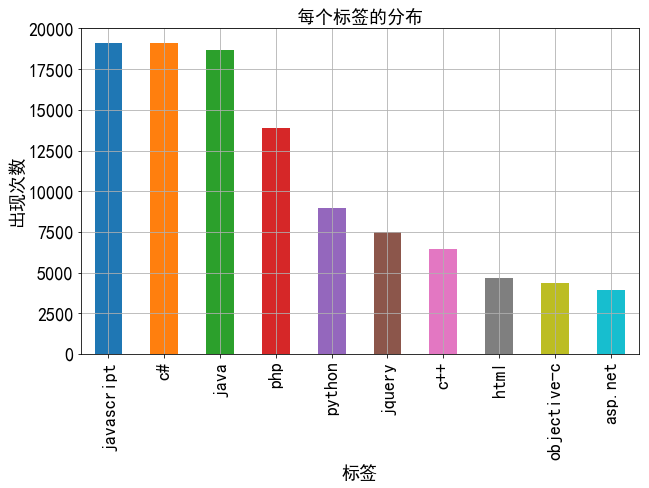

In [4]:
#前10个数量最多的标签分布
df[:10].plot(x='tag', y='count', kind='bar', legend=False, grid=True, figsize=(10, 6),fontsize=18)
plt.title("每个标签的分布",fontsize=18)
plt.ylabel('出现次数', fontsize=18)
plt.xlabel('标签', fontsize=18)

Text(0.5,0,'标签数')

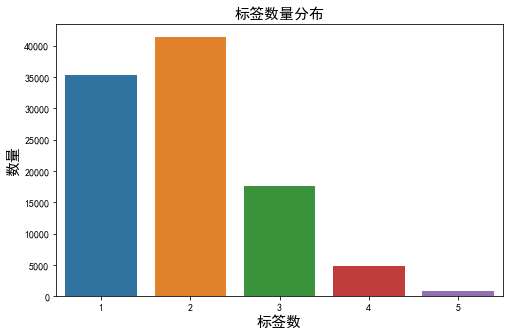

In [5]:
tagCount=train['tags'].apply(lambda x : len(x))
x = tagCount.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("标签数量分布",fontsize=15)
plt.ylabel('数量', fontsize=15)
plt.xlabel('标签数', fontsize=15)

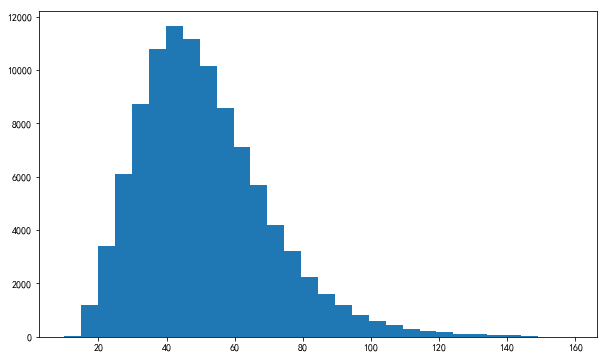

In [6]:
lens = train.title.str.len()
lens.hist(bins = 30,figsize=(10, 6),grid=False)

In [7]:
print('title 为空的数量:',train['title'].isnull().sum())
print('tags 为空的数量:',train['tags'].isnull().sum())

title 为空的数量: 0
tags 为空的数量: 0


In [8]:
#用空格替换各种符号
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') 
#删除各种符号
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
#定义数据清洗函数
def text_prepare(text):
    text = text.lower() # 字母小写化
    text = REPLACE_BY_SPACE_RE.sub(' ',text) 
    text = BAD_SYMBOLS_RE.sub('',text)    
    text = ' '.join([w for w in text.split() if w not in STOPWORDS]) # 删除停用词
    return text

In [11]:
X_train, y_train = train.title, train.tags
X_val, y_val = validation.title, validation.tags

#开始进行数据清洗
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_train[:10]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php']

In [29]:
cv = CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature = cv.fit_transform(X_train)
print(feature.shape)
print()
print(feature)

(100000, 18300)

  (0, 12748)	1
  (0, 14941)	1
  (0, 4792)	1
  (1, 4093)	1
  (1, 14054)	1
  (1, 10426)	1
  (1, 17129)	1
  (1, 14801)	1
  (1, 9077)	1
  (1, 5815)	1
  (1, 4089)	1
  (1, 13008)	1
  (1, 14019)	1
  (1, 10394)	1
  (2, 244)	1
  (2, 11718)	1
  (2, 17871)	1
  (2, 887)	1
  (2, 243)	1
  (2, 11715)	1
  (2, 17849)	1
  (2, 15706)	1
  (3, 17433)	1
  (3, 15916)	1
  (3, 3742)	1
  :	:
  (99997, 5228)	1
  (99997, 14548)	1
  (99997, 14224)	1
  (99997, 13991)	1
  (99997, 12611)	1
  (99997, 11406)	1
  (99997, 12531)	1
  (99998, 4861)	1
  (99998, 5462)	1
  (99998, 925)	1
  (99998, 5453)	1
  (99998, 4856)	1
  (99998, 2418)	1
  (99998, 14702)	1
  (99998, 7068)	1
  (99998, 8650)	1
  (99998, 13655)	1
  (99998, 8189)	1
  (99998, 15887)	1
  (99998, 6669)	1
  (99999, 3581)	1
  (99999, 12248)	1
  (99999, 7998)	1
  (99999, 9242)	1
  (99999, 3554)	1


In [30]:
tfidf = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature = tfidf.fit_transform(X_train)
print(feature.shape)
print()
print(feature)

(100000, 18300)

  (0, 4792)	0.5535025387941576
  (0, 14941)	0.7126565202061851
  (0, 12748)	0.4309937630129157
  (1, 10394)	0.20888863770024907
  (1, 14019)	0.22859508855051242
  (1, 13008)	0.2975359437533551
  (1, 4089)	0.2692803496632626
  (1, 5815)	0.2382368446529078
  (1, 9077)	0.3287166709387216
  (1, 14801)	0.29994308533196384
  (1, 17129)	0.18110148646398525
  (1, 10426)	0.3621376616529093
  (1, 14054)	0.4089312040982416
  (1, 4093)	0.39639224964237335
  (2, 15706)	0.39670241033325887
  (2, 17849)	0.2351453036010898
  (2, 11715)	0.3142739731167221
  (2, 243)	0.3716293832627843
  (2, 887)	0.24411894290285438
  (2, 17871)	0.3339121637039692
  (2, 11718)	0.3941792153794798
  (2, 244)	0.47327445521243877
  (3, 6669)	0.1692707961113005
  (3, 3725)	0.2552495715162359
  (3, 15887)	0.2234965219589451
  :	:
  (99997, 12611)	0.34104556902584193
  (99997, 13991)	0.3067513613267025
  (99997, 14224)	0.31389333347252774
  (99997, 14548)	0.37281164824471513
  (99997, 5228)	0.38155271570832655

In [35]:
#生成多标签的词袋矩阵
mlb = MultiLabelBinarizer(classes=sorted(tag_dic.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)
print(y_train.shape)
print(train.tags[0])
print(y_train[0])

(100000, 100)
['r']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_val, predicted):
    accuracy=accuracy_score(y_val, predicted)
    f1_score_macro=f1_score(y_val, predicted, average='macro')
    f1_score_micro=f1_score(y_val, predicted, average='micro')
    f1_score_weighted=f1_score(y_val, predicted, average='weighted')
    print("accuracy:",accuracy)
    print("f1_score_macro:",f1_score_macro)
    print("f1_score_micro:",f1_score_micro)
    print("f1_score_weighted:",f1_score_weighted)
#     print("precision_macro:",precision_macro)
#     print("precision_micro:",precision_micro)
#     print("precision_weighted:",precision_weighted)

### 1.TF-IDF+朴素贝叶斯

In [45]:
#朴素贝叶斯模型
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])

NB_pipeline.fit(X_train,y_train)
predicted = NB_pipeline.predict(X_val)
print_evaluation_scores(y_val,predicted)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 0.19816666666666666
f1_score_macro: 0.1106804556671684
f1_score_micro: 0.4602042387232514
f1_score_weighted: 0.398129431834211


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2. TF-IDF+线性支持向量机

In [39]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

SVC_pipeline.fit(X_train,y_train)
predicted = SVC_pipeline.predict(X_val)
print_evaluation_scores(y_val,predicted)

accuracy: 0.3762666666666667
f1_score_macro: 0.5206782843884173
f1_score_micro: 0.6849080977713582
f1_score_weighted: 0.6614169003852886


### 3.TF-IDF+逻辑回归

In [40]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train,y_train)
predicted = LogReg_pipeline.predict(X_val)
print_evaluation_scores(y_val,predicted)

accuracy: 0.33393333333333336
f1_score_macro: 0.44570816904771116
f1_score_micro: 0.6418085281077235
f1_score_weighted: 0.614350867051105


### 4. CountVectorizer+朴素贝叶斯 

In [41]:
NB_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

NB_pipeline.fit(X_train,y_train)
predicted = NB_pipeline.predict(X_val)
print_evaluation_scores(y_val,predicted)

accuracy: 0.28733333333333333
f1_score_macro: 0.4494407482839465
f1_score_micro: 0.6405520891066098
f1_score_weighted: 0.6270586794953129


### 5. CountVectorizer+线性支持向量机  

In [42]:
SVC_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

SVC_pipeline.fit(X_train,y_train)
predicted = SVC_pipeline.predict(X_val)
print_evaluation_scores(y_val,predicted)


accuracy: 0.3384333333333333
f1_score_macro: 0.5166982868428124
f1_score_micro: 0.6618965500814604
f1_score_weighted: 0.6495951881680853


### 6. CountVectorizer+逻辑回归  

In [44]:
LogReg_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train,y_train)
predicted = LogReg_pipeline.predict(X_val)
print_evaluation_scores(y_val,predicted)

accuracy: 0.35923333333333335
f1_score_macro: 0.5067686700489948
f1_score_micro: 0.6745877038274699
f1_score_weighted: 0.6525450161539913
